In [1]:
from google.colab import drive
from os.path import join
ROOT = "/content/drive"
print(ROOT)
drive.mount(ROOT)

/content/drive
Mounted at /content/drive


# 서울시 부동산 전월세가 예측 모델 구축
내년에 이사를 해야해서 부동산 정보를 찾아보던 중, 내년 서울시의 부동산 전월세가가 어떻게 될지 궁금해짐. 이에 LSTM 모델을 사용해 2020, 2021년도 서울시 부동산 전월세가 데이터로 서울시 부동산 전월세가를 예측해보았다.

## 사용 데이터
서울열린데이터광장의 서울시 부동산 전월세가 정보

## 사용 모델
LSTM
CNN + LSTM


In [2]:
import pandas as pd

seoul_house = pd.read_csv('/content/drive/MyDrive/Github/Deep-Learning-Final/서울시 부동산 전월세가 정보.csv', encoding='cp949')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (18,19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
seoul_house

,접수연도,자치구코드,자치구명,법정동코드,법정동명,지번구분,지번구분명,본번,부번,층,...,보증금(만원),임대료(만원),건물명,건축년도,건물용도,계약기간,신규갱신여부,계약갱신권사용여부,종전 보증금,종전 임대료
0,2022,11500,강서구,10500,마곡동,1.0,대지,760.0,0.0,3.0,...,17500,0,마곡나루역보타닉푸르지오시티,2017.0,오피스텔,NaN,NaN,NaN,NaN,NaN
1,2022,11305,강북구,10300,수유동,1.0,대지,190.0,24.0,6.0,...,7875,0,코지하우스,2013.0,연립다세대,NaN,NaN,NaN,NaN,NaN
2,2022,11440,마포구,11000,노고산동,1.0,대지,107.0,36.0,3.0,...,22000,0,현대벤처빌,2002.0,아파트,NaN,NaN,NaN,NaN,NaN
3,2022,11500,강서구,10500,마곡동,1.0,대지,760.0,0.0,10.0,...,16500,0,마곡나루역보타닉푸르지오시티,2017.0,오피스텔,NaN,NaN,NaN,NaN,NaN
4,2022,11710,송파구,10600,삼전동,1.0,대지,101.0,7.0,2.0,...,1000,58,(101-7),2002.0,연립다세대,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
639995,2021,11260,중랑구,10300,중화동,NaN,NaN,NaN,NaN,NaN,...,3000,30,NaN,1982.0,단독다가구,21.08~23.08,NaN,NaN,NaN,NaN
639996,2021,11305,강북구,10300,수유동,NaN,NaN,NaN,NaN,NaN,...,14000,0,NaN,1995.0,단독다가구,21.08~23.08,NaN,NaN,NaN,NaN
639997,2021,11500,강서구,10300,화곡동,1.0,대지,926.0,10.0,11.0,...,5770,0,행복타운(926-10),2012.0,아파트,21.06~23.06,NaN,NaN,NaN,NaN
639998,2021,11560,영등포구,13300,대림동,NaN,NaN,NaN,NaN,NaN,...,13000,0,NaN,1991.0,단독다가구,21.08~23.07,신규,NaN,NaN,NaN


In [4]:
seoul_house = seoul_house.loc[:, ['접수연도', '자치구코드', '자치구명', '법정동코드', '법정동명', '계약일', '전월세 구분', '임대면적(㎡)', '보증금(만원)', '건축년도', '건물용도']]

In [5]:
seoul_house

,접수연도,자치구코드,자치구명,법정동코드,법정동명,계약일,전월세 구분,임대면적(㎡),보증금(만원),건축년도,건물용도
0,2022,11500,강서구,10500,마곡동,20221216,전세,22.17,17500,2017.0,오피스텔
1,2022,11305,강북구,10300,수유동,20221216,전세,14.71,7875,2013.0,연립다세대
2,2022,11440,마포구,11000,노고산동,20221216,전세,34.64,22000,2002.0,아파트
3,2022,11500,강서구,10500,마곡동,20221216,전세,19.65,16500,2017.0,오피스텔
4,2022,11710,송파구,10600,삼전동,20221216,월세,29.08,1000,2002.0,연립다세대
...,...,...,...,...,...,...,...,...,...,...,...
639995,2021,11260,중랑구,10300,중화동,20210622,월세,51.00,3000,1982.0,단독다가구
639996,2021,11305,강북구,10300,수유동,20210622,전세,58.00,14000,1995.0,단독다가구
639997,2021,11500,강서구,10300,화곡동,20210622,전세,12.24,5770,2012.0,아파트
639998,2021,11560,영등포구,13300,대림동,20210622,전세,57.16,13000,1991.0,단독다가구


### 결측치 제거

In [6]:
drop_seoul_house = seoul_house.dropna(axis=0)

### 컬럼명 사용하기 쉽게 변경

In [7]:
drop_seoul_house.rename(columns={'전월세 구분':'전월세구분', '보증금(만원)':'보증금'}, inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


### 전세값만 사용

In [8]:
seoul_house_charter = (drop_seoul_house.전월세구분 == '전세')

In [9]:
seoul_house = drop_seoul_house[seoul_house_charter]

### 광진구 데이터만 사용

In [10]:
gwangjin_house = (seoul_house.자치구명 == '광진구')

In [11]:
gwangjin = seoul_house[gwangjin_house]

### 계약일과 보증금 데이터만 가져와 계약일을 인덱스로 하는 데이터프레임 구조로 바꿈

In [12]:
group = gwangjin.groupby(['계약일'])['보증금'].mean()
group = group.reset_index()
group.head()

,계약일,보증금
0,20210622,30109.722222
1,20210623,29613.888889
2,20210624,22993.260870
3,20210625,37176.000000
4,20210626,39826.538462


In [13]:
group = group.set_index(keys='계약일')
group

,보증금
계약일,
20210622,30109.722222
20210623,29613.888889
20210624,22993.260870
20210625,37176.000000
20210626,39826.538462
...,...
20221212,23277.000000
20221213,20769.230769
20221214,20445.000000


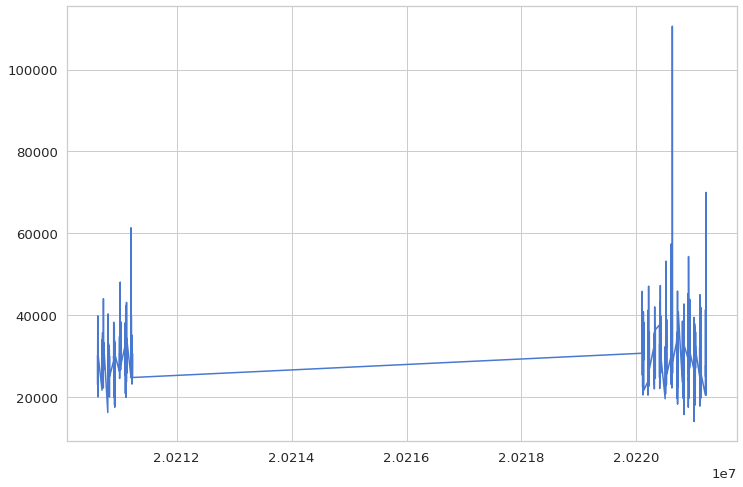

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

plt.plot(group)
plt.show()

# 시퀀스 데이터로 데이터 전처리

In [15]:
import numpy as np
from sklearn.model_selection import train_test_split

def create_sequences(data, seq_length):
  xs = []
  ys = []
  for i in range(len(data)-seq_length):
    x=data.iloc[i:(i+seq_length)]
    y=data.iloc[i+seq_length]
    xs.append(x)
    ys.append(y)
  return np.array(xs), np.array(ys)

seq_length=5
X, y = create_sequences(group, seq_length)


In [16]:
X.shape, y.shape

((532, 5, 1), (532, 1))

In [17]:
train_size=int(532*0.6)
print(train_size)

319


In [18]:
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+107], y[train_size:train_size+107]
X_test, y_test = X[train_size+106:], y[train_size+106:]

In [19]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(319, 5, 1) (107, 5, 1) (107, 5, 1)
(319, 1) (107, 1) (107, 1)


In [20]:
MIN = X_train.min()
MAX = X_train.max()
print(MIN, MAX)

16194.444444444445 61358.333333333336


In [21]:
def MinMaxScale(array, min, max):
  return (array-min)/(max-min)

In [22]:
X_train = MinMaxScale(X_train, MIN, MAX)
y_train = MinMaxScale(y_train, MIN, MAX)
X_val = MinMaxScale(X_val, MIN, MAX)
y_val = MinMaxScale(y_val, MIN, MAX)
X_test = MinMaxScale(X_test, MIN, MAX)
y_test = MinMaxScale(y_test, MIN, MAX)

In [23]:
import torch

def make_Tensor(array):
  return torch.from_numpy(array).float()

In [24]:
X_train = make_Tensor(X_train)
y_train = make_Tensor(y_train)
X_val = make_Tensor(X_val)
y_val = make_Tensor(y_val)
X_test = make_Tensor(X_test)
y_test = make_Tensor(y_test)

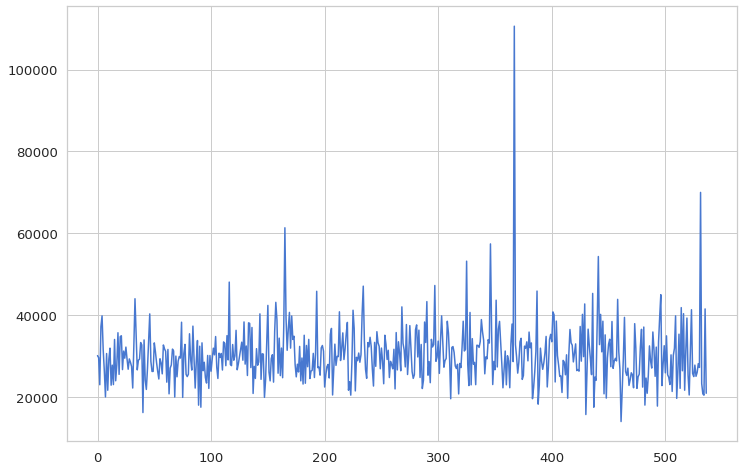

In [25]:
plt.plot(group.values)

In [51]:
from torch import nn, optim

class HousePredictor(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers):
        super(HousePredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers
        )
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
        )
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(
            sequences.view(len(sequences), self.seq_len, -1),
            self.hidden
        )
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred

In [52]:
def train_model(model, train_data, train_labels, val_data=None, val_labels=None, num_epochs=100, verbose = 10, patience = 10):
    loss_fn = torch.nn.L1Loss() #
    optimiser = torch.optim.Adam(model.parameters(), lr=0.0001)
    train_hist = []
    val_hist = []
    for t in range(num_epochs):

        epoch_loss = 0

        for idx, seq in enumerate(train_data): 

            model.reset_hidden_state() # seq 별 hidden state reset

            # train loss
            seq = torch.unsqueeze(seq, 0)
            y_pred = model(seq)
            loss = loss_fn(y_pred[0].float(), train_labels[idx]) # 1개의 step에 대한 loss

            # update weights
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            epoch_loss += loss.item()

        train_hist.append(epoch_loss / len(train_data))

        if val_data is not None:

            with torch.no_grad():

                val_loss = 0

                for val_idx, val_seq in enumerate(val_data):

                    model.reset_hidden_state() # seq 별로 hidden state 초기화 

                    val_seq = torch.unsqueeze(val_seq, 0)
                    y_val_pred = model(val_seq)
                    val_step_loss = loss_fn(y_val_pred[0].float(), val_labels[val_idx])

                    val_loss += val_step_loss
                
            val_hist.append(val_loss / len(val_data)) # val hist에 추가

            ## verbose 번째 마다 loss 출력 
            if t % verbose == 0:
                print(f'Epoch {t} train loss: {epoch_loss / len(train_data)} val loss: {val_loss / len(val_data)}')

            ## patience 번째 마다 early stopping 여부 확인
            if (t % patience == 0) & (t != 0):
                
                ## loss가 커졌다면 early stop
                if val_hist[t - patience] < val_hist[t] :

                    print('\n Early Stopping')

                    break

        elif t % verbose == 0:
            print(f'Epoch {t} train loss: {epoch_loss / len(train_data)}')

            
    return model, train_hist, val_hist

In [53]:
model = HousePredictor(
    n_features=1,
    n_hidden=4,
    seq_len=seq_length,
    n_layers=1
)
model, train_hist, val_hist = train_model(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    num_epochs=100,
    verbose=10,
    patience=50
)

Epoch 0 train loss: 0.7107356221511446 val loss: 0.7114158868789673
Epoch 10 train loss: 0.09782237001347317 val loss: 0.12720488011837006
Epoch 20 train loss: 0.09740509144191084 val loss: 0.12653683125972748
Epoch 30 train loss: 0.097083291570221 val loss: 0.12610265612602234
Epoch 40 train loss: 0.0968639159744436 val loss: 0.12577052414417267
Epoch 50 train loss: 0.0966965299228142 val loss: 0.12548263370990753
Epoch 60 train loss: 0.09653842458530654 val loss: 0.12517273426055908
Epoch 70 train loss: 0.09642939012626121 val loss: 0.12496436387300491
Epoch 80 train loss: 0.09632217510366889 val loss: 0.12476293742656708
Epoch 90 train loss: 0.0962162080416485 val loss: 0.12456182390451431


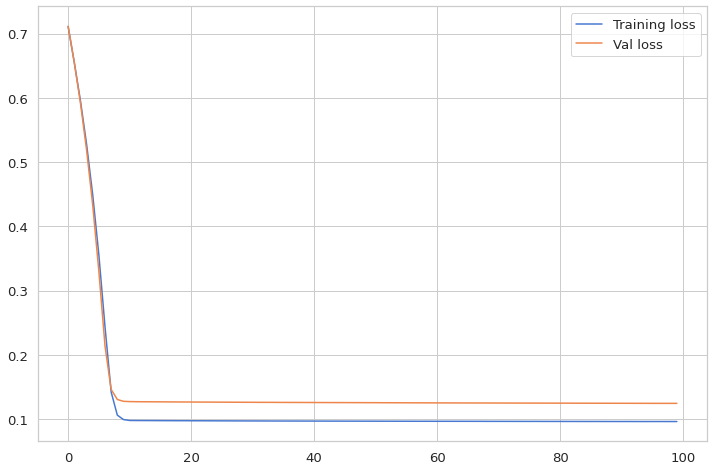

In [54]:
plt.plot(train_hist, label="Training loss")
plt.plot(val_hist, label="Val loss")
plt.legend()

In [55]:
pred_dataset = X_test

with torch.no_grad():
    preds = []
    for _ in range(len(pred_dataset)):
        model.reset_hidden_state()
        y_test_pred = model(torch.unsqueeze(pred_dataset[_], 0))
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)

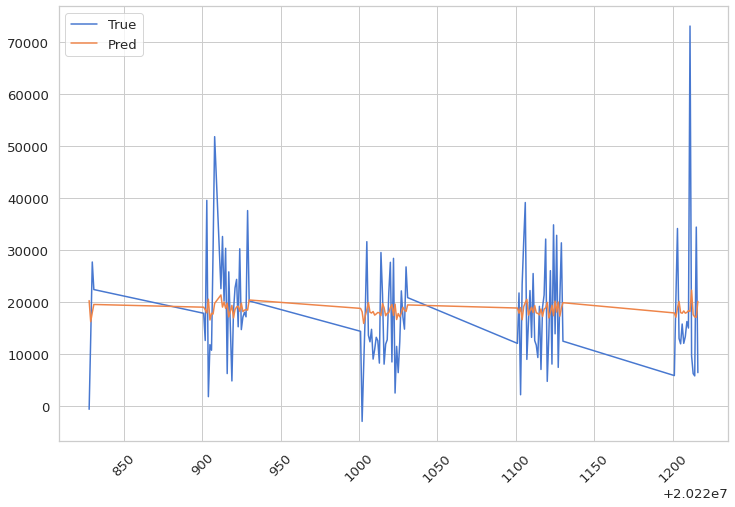

In [56]:
plt.plot(group.index[-len(y_test):], np.array(y_test) * MAX, label='True')
plt.plot(group.index[-len(preds):], np.array(preds) * MAX, label='Pred')
plt.xticks(rotation=45)
plt.legend()

In [57]:
def MAE(true, pred):
    return np.mean(np.abs(true-pred))

In [58]:
MAE(np.array(y_test)*MAX, np.array(preds)*MAX)

8620.524422952189

In [59]:
with torch.no_grad():
    test_seq = X_test[:1] # 첫번째 테스트 셋, 3차원
    preds = []
    for _ in range(len(X_test)):
        model.reset_hidden_state()
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred]) # 시퀀스에 추가 
        new_seq = new_seq[1:] # 추가된 값을 포함하여 seq_length가 5개가 되도록 맞추기 
        test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

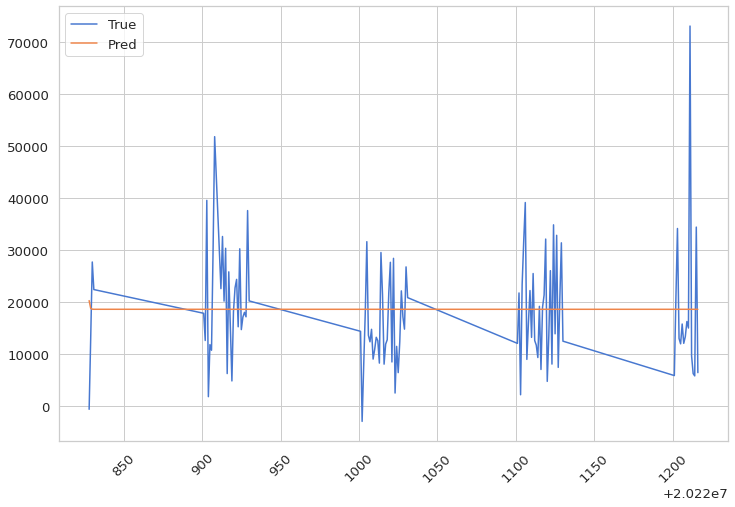

In [60]:
plt.plot(group.index[-len(y_test):], np.array(y_test) * MAX, label='True')
plt.plot(group.index[-len(preds):], np.array(preds) * MAX, label='Pred')
plt.xticks(rotation=45)
plt.legend()

In [62]:
MAE(np.array(y_test)*MAX, np.array(preds)*MAX)

8619.297185886191

In [63]:
c = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=2, stride=1)
input = torch.Tensor([[[1,2,3,4,5]]])
output = c(input)
output

tensor([[[-0.7756, -0.8905, -1.0055, -1.1204]]],
       grad_fn=<ConvolutionBackward0>)

In [64]:
for param in c.parameters():
    print(param)

Parameter containing:
tensor([[[-0.1442,  0.0293]]], requires_grad=True)
Parameter containing:
tensor([-0.6900], requires_grad=True)


In [65]:
w_list = []
for param in c.parameters():
    w_list.append(param)

w = w_list[0]
b = w_list[1]

w1 = w[0][0][0]
w2 = w[0][0][1]

print(w1)
print(w2)
print(b)

tensor(-0.1442, grad_fn=<SelectBackward0>)
tensor(0.0293, grad_fn=<SelectBackward0>)
Parameter containing:
tensor([-0.6900], requires_grad=True)


In [67]:
w1 * 3 + w2 * 4 + b

tensor([-1.0055], grad_fn=<AddBackward0>)

In [68]:
output

tensor([[[-0.7756, -0.8905, -1.0055, -1.1204]]],
       grad_fn=<ConvolutionBackward0>)

In [69]:
class CovidPredictor(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers):
        super(CovidPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.c1 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size = 2, stride = 1) # 1D CNN 레이어 추가
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers
        )
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len-1, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len-1, self.n_hidden)
        )
    def forward(self, sequences):
        sequences = self.c1(sequences.view(len(sequences), 1, -1))
        lstm_out, self.hidden = self.lstm(
            sequences.view(len(sequences), self.seq_len-1, -1),
            self.hidden
        )
        last_time_step = lstm_out.view(self.seq_len-1, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred

In [70]:
def train_model(model, train_data, train_labels, val_data=None, val_labels=None, num_epochs=100, verbose = 10, patience = 10):
    loss_fn = torch.nn.L1Loss() #
    optimiser = torch.optim.Adam(model.parameters(), lr=0.0001)
    train_hist = []
    val_hist = []
    for t in range(num_epochs):

        epoch_loss = 0

        for idx, seq in enumerate(train_data): # sample 별 hidden state reset을 해줘야 함 

            model.reset_hidden_state()

            # train loss
            seq = torch.unsqueeze(seq, 0)
            y_pred = model(seq)
            loss = loss_fn(y_pred[0].float(), train_labels[idx]) # 1개의 step에 대한 loss

            # update weights
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            epoch_loss += loss.item()

        train_hist.append(epoch_loss / len(train_data))

        if val_data is not None:

            with torch.no_grad():

                val_loss = 0

                for val_idx, val_seq in enumerate(val_data):

                    model.reset_hidden_state() #seq 별로 hidden state 초기화 

                    val_seq = torch.unsqueeze(val_seq, 0)
                    y_val_pred = model(val_seq)
                    val_step_loss = loss_fn(y_val_pred[0].float(), val_labels[val_idx])

                    val_loss += val_step_loss
                
            val_hist.append(val_loss / len(val_data)) # val hist에 추가

            ## verbose 번째 마다 loss 출력 
            if t % verbose == 0:
                print(f'Epoch {t} train loss: {epoch_loss / len(train_data)} val loss: {val_loss / len(val_data)}')

            ## patience 번째 마다 early stopping 여부 확인
            if (t % patience == 0) & (t != 0):
                
                ## loss가 커졌다면 early stop
                if val_hist[t - patience] < val_hist[t] :

                    print('\n Early Stopping')

                    break

        elif t % verbose == 0:
            print(f'Epoch {t} train loss: {epoch_loss / len(train_data)}')

            
    return model, train_hist, val_hist

In [71]:
model = CovidPredictor(
    n_features=1,
    n_hidden=4,
    seq_len=seq_length,
    n_layers=1
)

In [72]:
print(model)

CovidPredictor(
  (c1): Conv1d(1, 1, kernel_size=(2,), stride=(1,))
  (lstm): LSTM(1, 4)
  (linear): Linear(in_features=4, out_features=1, bias=True)
)


In [73]:
model, train_hist, val_hist = train_model(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    num_epochs=100,
    verbose=10,
    patience=50
)

Epoch 0 train loss: 0.2859202243904452 val loss: 0.28426557779312134
Epoch 10 train loss: 0.09524217266647793 val loss: 0.12500496208667755
Epoch 20 train loss: 0.09523279670637604 val loss: 0.12484774738550186
Epoch 30 train loss: 0.09525198407681384 val loss: 0.12485668808221817
Epoch 40 train loss: 0.09524894274514296 val loss: 0.12486452609300613
Epoch 50 train loss: 0.09524597960953428 val loss: 0.12487157434225082
Epoch 60 train loss: 0.095243099247774 val loss: 0.12487784028053284
Epoch 70 train loss: 0.09524033921639374 val loss: 0.12488292157649994
Epoch 80 train loss: 0.09523768727682227 val loss: 0.12488674372434616
Epoch 90 train loss: 0.09521288726023372 val loss: 0.1248888447880745


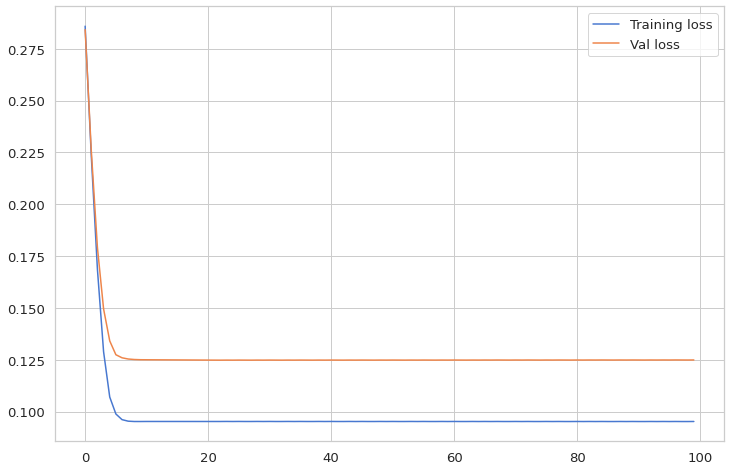

In [74]:
plt.plot(train_hist, label="Training loss")
plt.plot(val_hist, label="Val loss")
plt.legend()

In [75]:
pred_dataset = X_test

with torch.no_grad():
    preds = []
    for _ in range(len(pred_dataset)):
        model.reset_hidden_state()
        y_test_pred = model(torch.unsqueeze(pred_dataset[_], 0))
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)

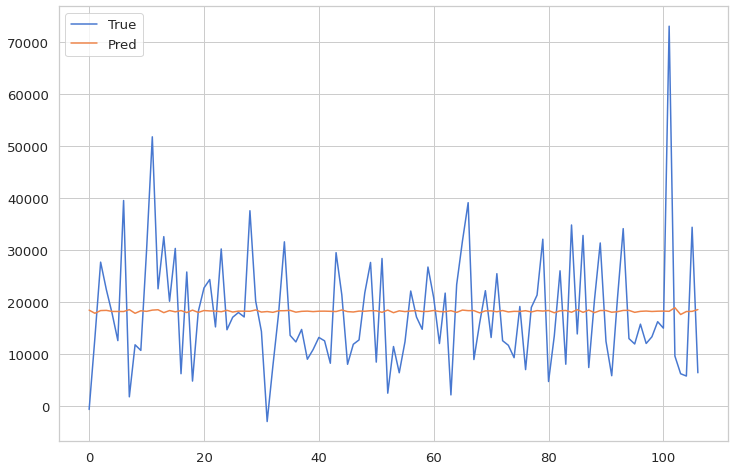

In [76]:
plt.plot(np.array(y_test)*MAX, label = 'True')
plt.plot(np.array(preds)*MAX, label = 'Pred')
plt.legend()

In [49]:
def MAE(true, pred):
    return np.mean(np.abs(true-pred))

In [50]:
MAE(np.array(y_test)*MAX, np.array(preds)*MAX)

8531.485731346866